# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

## Problem Statement

Starbucks has about 32,660 stores across the globe. Within a month, 37.8 million Americans visited a Starbucks. With this many customers, there are a lot of data that Starbucks can use to promote their brand. By analyzing their customer behavior they can make decisions based on target audiences. Using customer, offer and transactional data Starbucks would like to gain insights and know the effectiveness of offers.

The objective is to build a machine learning model that predicts whether or not a customer will respond to an offer.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

### Table of Contents

1. [Exploratory Data Analysis](#eda)
    1. [Portfolio](#portfolio)
    2. [Profile](#profile)
    3. [Transcript](#transcript)
2. [Preprocessing](#preprocess)
    1. [Clean and Merge Data](#clean-merge)
    2. [Feature Scaling](#scaling)
    3. [Split Train & Test](#split-train-test)
3. [Modeling](#modeling)
    1. [Tuning Model](#tuning)
    2. [Feature Importance](#feat-imp)
4. [Reflection](#reflection)
5. [Improvements](#improve)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score, fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

% matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 1. EDA <a id='eda'></a>

### A. Portfolio <a href='portfolio'></a>

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [5]:
# Check for missing values
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

**No missing values. Great!**

In [6]:
portfolio.shape

(10, 6)

In [7]:
# Rename id column to offer_id (linked to transcript)
portfolio.rename(columns = {'id': 'offer_id'}, inplace = True)

# Rename duration to offer_duration
portfolio.rename(columns = {'duration': 'offer_duration'}, inplace = True)

In [8]:
portfolio['offer_type'].value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

**Three types of Starbucks offers: 4 BOGO, 2 Informational and 4 Discount**

In [9]:
portfolio['offer_duration'].value_counts()

7     4
10    2
5     2
4     1
3     1
Name: offer_duration, dtype: int64

### B. Profile <a id='profile'></a>

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [10]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [11]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [12]:
profile.dtypes

age                   int64
became_member_on      int64
gender               object
id                   object
income              float64
dtype: object

In [13]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [14]:
profile.shape

(17000, 5)

In [15]:
print('There are {} unique ids'.format(profile['id'].nunique()))

There are 17000 unique ids


**Since the number of rows and number of ids are the same, there are no duplicates.**

In [16]:
# Rename id to customer_id
profile.rename(columns = {'id': 'customer_id'}, inplace = True)

In [17]:
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [18]:
profile['age'].value_counts()

118    2175
58      408
53      372
51      363
54      359
59      359
57      353
52      351
55      350
56      342
63      338
60      333
49      321
62      318
67      317
64      311
61      309
48      288
50      284
66      284
65      280
68      259
70      252
69      242
47      232
45      231
71      230
42      227
43      215
46      212
       ... 
22      131
30      131
29      129
23      126
81      118
35      118
79      117
80      116
31      113
82      105
83      102
84       83
18       70
85       70
87       66
88       64
86       54
89       53
90       52
91       47
92       40
94       33
93       29
95       22
97       13
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64

In [19]:
profile[profile['age'] == 118].head()

,age,became_member_on,gender,customer_id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]),
 <a list of 85 Text xticklabel objects>)

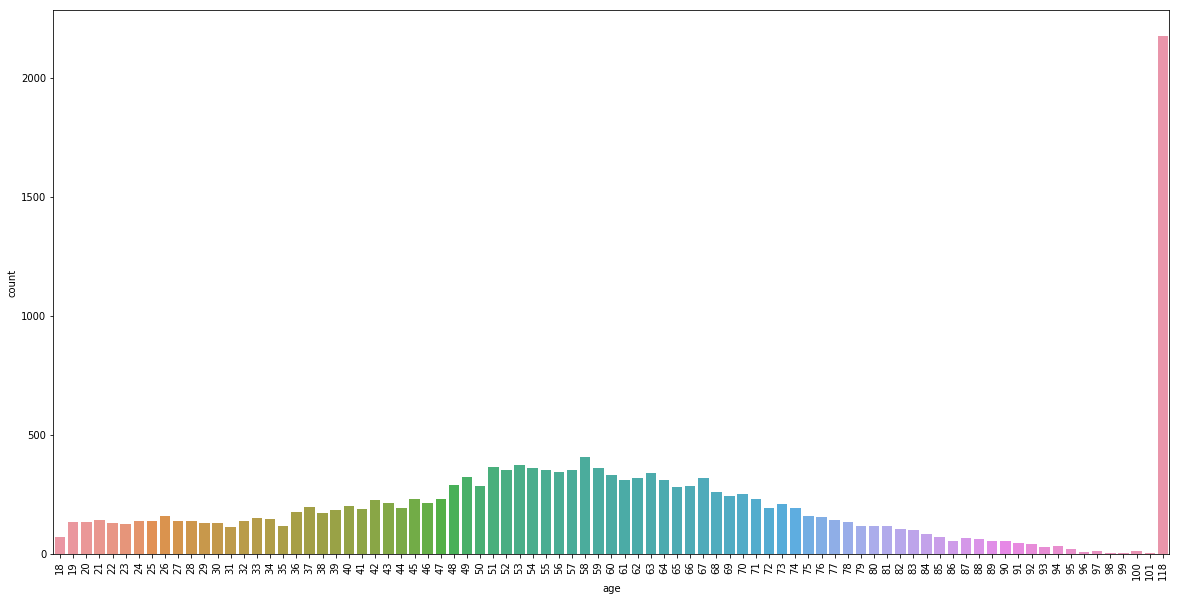

In [20]:
plt.figure(figsize = (20,10))
sns.countplot(profile['age'])
plt.xticks(rotation = 90)

**The number of profiles with an age of 118 is 2175, this matches the number of missing values. This means age of 118 is a dummy value. As these rows with age of 118 also have missing values for gender and income, it is justifiable to drop these rows.**

In [21]:
# Extract customer_id with age of 118 for transcript dataframe
id_118 = profile['customer_id'].loc[profile['age'] == 118].values
id_118 = list(id_118)

In [22]:
# Remove rows with missing values
profile.drop(index = profile[profile['age'] == 118].index, inplace = True)

# became_member_on is a date but data type is currently int, so change to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')

profile.head()

,age,became_member_on,gender,customer_id,income
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


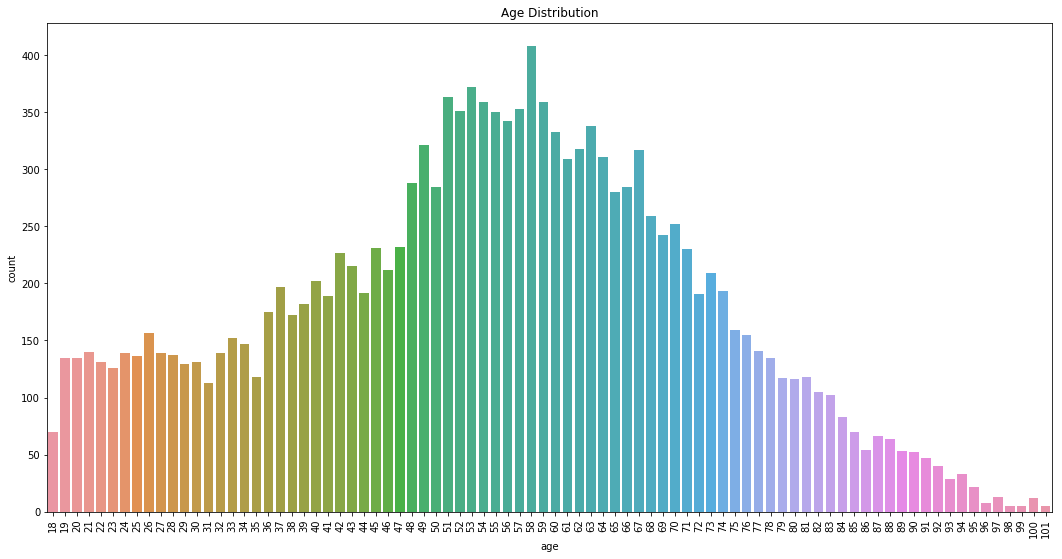

In [23]:
# Plot Age Distribution after dropping rows with age of 118
plt.figure(figsize = (18,9))
sns.countplot(data = profile, x = profile['age'])
plt.title('Age Distribution')
plt.xticks(rotation = 90)
plt.show()

**Very uniform age distribution!**

In [24]:
profile.groupby('gender')['income'].agg(['mean','median'])

,mean,median
gender,,
F,71306.412139,71000.0
M,61194.601603,59000.0
O,63287.735849,62000.0


**Seems like from data collected, females tend to earn more.**

In [25]:
def plot_income(df, gender):
    '''
    Plot income by gender
    
    Args:
        df: DataFrame containing profile data with income
        gender: String. Male/Female/Other
        
    Returns:
        None
    '''
    df['income_K'] = df['income'].apply(lambda x: x / 1000)
    
    plt.figure(figsize = (12,6))
    sns.distplot(df.loc[df['gender'] == gender[0], 'income_K'])
    plt.title('Income Distribution for {}'.format(gender))
    plt.xlabel('Income (Thousands)')

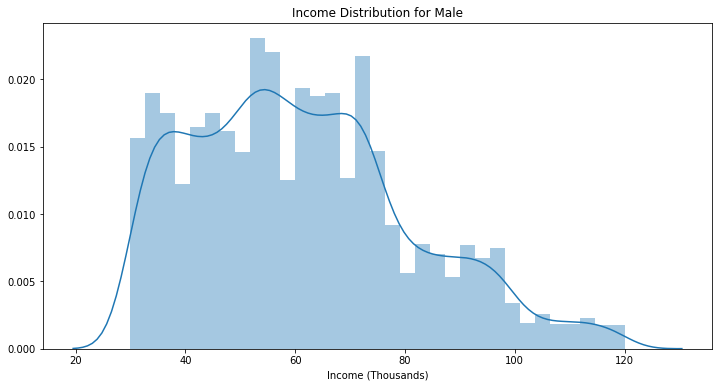

In [26]:
plot_income(profile, 'Male')

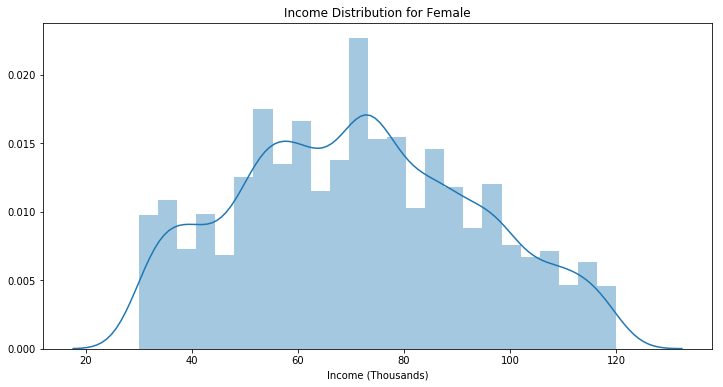

In [27]:
plot_income(profile, 'Female')

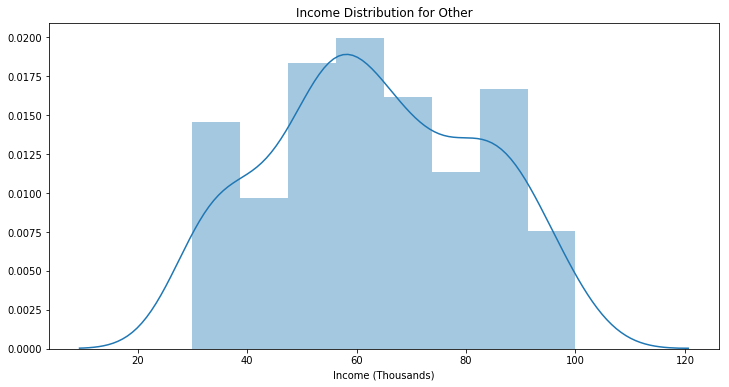

In [28]:
plot_income(profile, 'Other')

**As shown above the distribution of income for Males and Females are similar.**

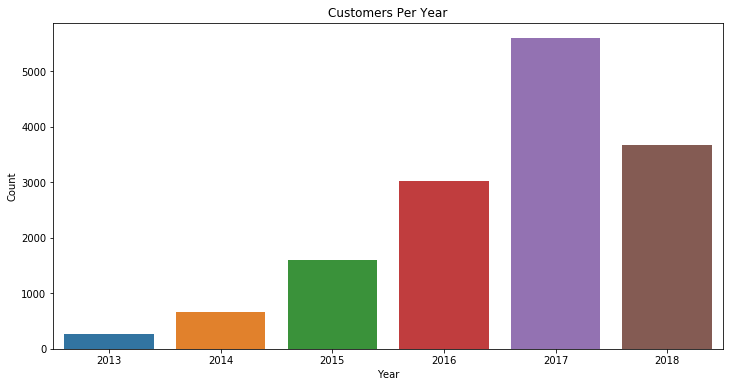

In [29]:
plt.figure(figsize = (12,6))
sns.countplot(data = profile, x = profile['became_member_on'].dt.year)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Customers Per Year')
plt.show()

**The number of new customers per year seems to be increasing overtime. However, in 2018 there was a drop which may be because the data was released in 2018. According to the trend we can expect an overall increasing trend as time passes.**

In [30]:
def profile_age(df):
    '''
    Rather than individual ages, categorize into age groups
    
    Args:
        df: DataFrame with an age column
        
    Returns:
        df: DataFrame with age groups and no individual ages
    '''
    #add Age_group column
    df.loc[(df.age < 20) , 'age_group'] = 'Under 20'
    df.loc[(df.age >= 20) & (df.age <= 29) , 'age_group'] = '20-29'
    df.loc[(df.age >= 30) & (df.age <= 39) , 'age_group'] = '30-39'
    df.loc[(df.age >= 40) & (df.age <= 49) , 'age_group'] = '40-49'
    df.loc[(df.age >= 50) & (df.age <= 59) , 'age_group'] = '50-59'
    df.loc[(df.age >= 61) , 'age_group'] = '60+'
    df.drop('age', axis = 1, inplace = True)
    
    return df

**We will bin customer age to prevent overfitting in the machine learning model.**

In [31]:
profile_age = profile_age(profile)

In [32]:
profile['member_duration'] = (datetime.today().date() - pd.to_datetime(profile['became_member_on'],\
                                                                     format='%Y%m%d').dt.date).dt.days
profile.drop(columns = 'became_member_on', inplace = True)

### C. Transcript <a id='transcript'></a>

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [33]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [34]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [35]:
transcript.dtypes

event     object
person    object
time       int64
value     object
dtype: object

In [36]:
transcript.shape

(306534, 4)

In [37]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

**No missing values!**

In [38]:
# Rename person column to customer_id
transcript.rename(columns = {'person': 'customer_id'}, inplace = True)
transcript.head()

,event,customer_id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [39]:
# Remove rows where customer_id matches the rows in the profile dataframe
transcript = transcript[~transcript['customer_id'].isin(id_118)]
transcript.shape

(272762, 4)

In [40]:
print('Number of unique IDs in profile: {}'.format(profile['customer_id'].nunique()))
print('Number of unique IDs in transcript: {}'.format(transcript['customer_id'].nunique()))

Number of unique IDs in profile: 14825
Number of unique IDs in transcript: 14825


**All IDs in profile appear in transcript.**

In [41]:
transcript['event'].value_counts(normalize = True) * 100

transaction        45.445113
offer received     24.380596
offer viewed       18.279672
offer completed    11.894619
Name: event, dtype: float64

In [42]:
print('Percentage of events are transactions: {:0.2f}%'.format(transcript['event'].value_counts(normalize = True)[0] * 100))
print('Percentage of events are offers: {:0.2f}%'.format(transcript['event'].value_counts(normalize = True)[1:].sum() * 100))

Percentage of events are transactions: 45.45%
Percentage of events are offers: 54.55%


**Almost a 50/50 split between offers and transactions.**

## 2. Preprocessing <a id='preprocess'></a>

### A. Clean and Merge Data <a id = "clean-merge"></a>

**Now we want to separate offers and transaction information, but first we need to solve the value column. In order to do this, let's find out what are the key names.**

In [43]:
# Separate transaction data and offer data
offer_lst = ['offer received', 'offer viewed', 'offer completed']

offer_events = transcript[transcript['event'].isin(offer_lst)]

transaction_events = transcript[~transcript['event'].isin(offer_lst)]

In [44]:
def clean_offers(x):
    '''
    Cleans offers_events value column so that instead of a dictionary it is a value.
    Applied to a lambda function.
    
    Args:
        x: Dictionary with offer id
        
    Returns:
        None
    '''
    for key, value in x.items():
        if key in ['offer id', 'offer_id']:
            return str(value)
        if key not in ['offer id', 'offer_id']:
            print('Please separate data again!')

In [45]:
offer_events['offer_id'] = offer_events['value'].apply(clean_offers)
offer_events.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,event,customer_id,time,value,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7


In [46]:
# Create a dictionary for offer id and their type
offer_type_df = portfolio[['offer_id', 'offer_type']]
offer_type_df

,offer_id,offer_type
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo
2,3f207df678b143eea3cee63160fa8bed,informational
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount
5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount
6,fafdcd668e3743c1bb461111dcafc2a4,discount
7,5a8bc65990b245e5a138643cd4eb9837,informational
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo
9,2906b810c7d4411798c6938adc9daaa5,discount


In [47]:
offer_events = pd.merge(offer_events, offer_type_df, on='offer_id')
offer_events.head()

,event,customer_id,time,value,offer_id,offer_type
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo
1,offer received,ebe7ef46ea6f4963a7dd49f501b26779,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo
2,offer received,f082d80f0aac47a99173ba8ef8fc1909,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo
3,offer received,c0d210398dee4a0895b24444a5fcd1d2,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo
4,offer received,57dd18ec5ddc46828afb81ec5977bef2,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo


In [48]:
# View count of events grouped by offer type
offer_events.groupby(['offer_type', 'event'])['customer_id'].count()

offer_type     event          
bogo           offer completed    15258
               offer received     26537
               offer viewed       22039
discount       offer completed    17186
               offer received     26664
               offer viewed       18461
informational  offer received     13300
               offer viewed        9360
Name: customer_id, dtype: int64

**Both BOGO and Discount have offer received, viewed and completed. Informational does not have offer completed so if a customer makes a purchase within a certain time after viewing the offer it will be considered completed.**

In [49]:
# Drop value as value is not needed and drop offer_type to prevent duplication when merging later
offer_events.drop(columns = ['value'], inplace = True)
offer_events.head()

,event,customer_id,time,offer_id,offer_type
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo
1,offer received,ebe7ef46ea6f4963a7dd49f501b26779,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo
2,offer received,f082d80f0aac47a99173ba8ef8fc1909,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo
3,offer received,c0d210398dee4a0895b24444a5fcd1d2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo
4,offer received,57dd18ec5ddc46828afb81ec5977bef2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo


In [50]:
# Encode event using get_dummies
offer_events = pd.get_dummies(data = offer_events, columns = ['event'])

# Rename columns
offer_events = offer_events.rename(columns = {'event_offer received': 'offer_received', 'event_offer viewed': 'offer_viewed',\
                                             'event_offer completed': 'offer_completed', 'offer_type': 'offer_type'})
# Reorder columns
offer_events = offer_events[['customer_id', 'time', 'offer_id', 'offer_received', 'offer_viewed', 'offer_completed',
                             'offer_type']]

# Convert time from hours to days
offer_events['time'] = offer_events['time'] / 24.0

offer_events.head()

,customer_id,time,offer_id,offer_received,offer_viewed,offer_completed,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,bogo
1,ebe7ef46ea6f4963a7dd49f501b26779,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,bogo
2,f082d80f0aac47a99173ba8ef8fc1909,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,bogo
3,c0d210398dee4a0895b24444a5fcd1d2,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,bogo
4,57dd18ec5ddc46828afb81ec5977bef2,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,bogo


In [51]:
offer_events['offer_type'][offer_events['offer_id'] == '9b98b8c7a33c4b65b9aebfe6a799e6d9'].values[0] == 'bogo'

True

In [52]:
transaction_events.head()

,event,customer_id,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


In [53]:
# Similar to offer_events, extract the value from the dictionary and create new column "amount"
transaction_events['amount'] = transaction_events['value'].apply(lambda x: x['amount'])

# Drop value column as it is no longer needed and event column to prevent duplications when merging
transaction_events.drop(columns = ['event', 'value'], inplace = True)

# Convert time from hours to days
transaction_events['time'] = transaction_events['time'] / 24.0
transaction_events.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,customer_id,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0.0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,34.56
12659,54890f68699049c2a04d415abc25e717,0.0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0.0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0.0,18.97


**Events are not a good indicator to whether or not a customer will respond to an offer. Therefore, in the merge_data function we will first need to aggregate the events corresponding to each customer. Then we will find whether or not each customer responded to an offer.**

In [54]:
def merged_data(portfolio, profile, offer_events, transaction_events):
    '''
    Returns a DataFrame with information about whether or not a customer
    responded to an offer.
    
    Args:
        portfolio: DataFrame with offer data/information
        profile: DataFrame with customer data
        offer_events: DataFrame with customer & offer data
        transaction_events: DataFrame with customer & transaction data
    
    Returns:
        merged_df: DataFrame with Args merged
    '''
    offers_response = []
    customer_ids = list(offer_events['customer_id'].unique())
        
    # Aggregate events to each customer by iterating over customer ids to determine customer response to an offer
    for c_id in customer_ids:
        customer_profile = profile[profile['customer_id'] == c_id]        
        customer_offers = offer_events[offer_events['customer_id'] == c_id]
        customer_transactions = transaction_events[transaction_events['customer_id'] == c_id]
        customer_received = customer_offers[customer_offers['offer_received'] == 1]
        customer_viewed = customer_offers[customer_offers['offer_viewed'] == 1]
        customer_complete = customer_offers[customer_offers['offer_completed'] == 1]
        
        c_offer_ids = list(customer_received['offer_id'].unique())
        
        for offer_id in c_offer_ids:
            offer_received = customer_offers['offer_received'][customer_offers['offer_id'] == offer_id].max()
            offer_viewed = customer_offers['offer_viewed'][customer_offers['offer_id'] == offer_id].max()
            offer_complete = customer_offers['offer_completed'][customer_offers['offer_id'] == offer_id].max()
            
            offer_duration = portfolio['offer_duration'].loc[portfolio['offer_id'] == offer_id].values[0]
            
            offer_received_t = customer_received['time'].loc[customer_received['offer_id'] == offer_id].values[0]

            offer_end = offer_received_t + offer_duration
            
            # Boolean is stored in variable customer_viewed_offer
            customer_viewed_offer = (customer_viewed['time'] >= offer_received_t) & \
                                    (customer_viewed['time'] <= offer_end)

            # Extract rows where customer made transactions within offer period
            transactions_within_time = customer_transactions[(customer_transactions['time'] >= offer_received_t) & \
                                                            (customer_transactions['time'] <= offer_end)]
            
            total_spending = transactions_within_time['amount'].sum()
            
            # 1 = Responded to offer or 0 = Did not respond to offer
            if customer_offers['offer_type'][customer_offers['offer_id'] == offer_id].values[0] == 'informational':
                response = int(offer_viewed and total_spending > 0)
                
                offers_response.append({'customer_id': c_id, 'offer_id': offer_id, 'offer_received': offer_received,
                                        'offer_viewed': offer_viewed, 'offer_completed': offer_complete, 
                                    'time': offer_received_t, 'total_spending': total_spending, 'response': response})    
            
            # Offer type is BOGO or Discount
            else:
                offers_completed = (customer_complete['time'] >= offer_received_t) & \
                                    (customer_complete['time'] <= offer_end)
                response = int((offer_viewed and offer_complete) and total_spending > 0)
            
                offers_response.append({'customer_id': c_id, 'offer_id': offer_id, 'offer_received': offer_received,
                                        'offer_viewed': offer_viewed, 'offer_completed': offer_complete,
                                        'time': offer_received_t, 'total_spending': total_spending,
                                        'response': response})
    
    offers_response_df = pd.DataFrame(offers_response)
    merged_df = pd.merge(profile, offers_response_df, on = 'customer_id')
    merged_df = pd.merge(merged_df, portfolio, on = 'offer_id')
    
    merged_df.to_csv('starbucks_merged_data.csv', index = False)
    
    return merged_df

In [55]:
filename = './starbucks_merged_data.csv'
try:
    merged_df = pd.read_csv(filename)
except:
    merged_df = merged_data(portfolio, profile, offer_events, transaction_events)

merged_df.head()

,gender,customer_id,income,income_K,age_group,member_duration,offer_completed,offer_id,offer_received,offer_viewed,response,time,total_spending,channels,difficulty,offer_duration,offer_type,reward
0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,112.0,50-59,1410,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,17.0,23.22,"['web', 'email', 'mobile']",5,7,bogo,5
1,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,100.0,60+,1477,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0.0,37.67,"['web', 'email', 'mobile']",5,7,bogo,5
2,M,e2127556f4f64592b11af22de27a7932,70000.0,70.0,60+,1125,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,17.0,18.42,"['web', 'email', 'mobile']",5,7,bogo,5
3,M,389bc3fa690240e798340f5a15918d5c,53000.0,53.0,60+,1201,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,7.0,0.00,"['web', 'email', 'mobile']",5,7,bogo,5
4,M,6445de3b47274c759400cd68131d91b4,42000.0,42.0,50-59,1241,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,14.0,1.14,"['web', 'email', 'mobile']",5,7,bogo,5


In [56]:
def encode_channels(df):
    '''
    Encodes the channels column
    
    Args:
        df: DataFrame with merged data
    
    Returns:
        df: DataFrame with merged data and encoded channels
    '''
    dummy = df['channels'].apply(lambda x: str(x)[1:-1].replace('\'',''))
    dummy = dummy.str.get_dummies(sep = ', ')
    df = pd.concat([df, dummy], axis = 1)
    df.drop(columns = 'channels', inplace = True)
    
    return df

In [57]:
merged_df = encode_channels(merged_df)
merged_df.head()

,gender,customer_id,income,income_K,age_group,member_duration,offer_completed,offer_id,offer_received,offer_viewed,...,time,total_spending,difficulty,offer_duration,offer_type,reward,email,mobile,social,web
0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,112.0,50-59,1410,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,...,17.0,23.22,5,7,bogo,5,1,1,0,1
1,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,100.0,60+,1477,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,...,0.0,37.67,5,7,bogo,5,1,1,0,1
2,M,e2127556f4f64592b11af22de27a7932,70000.0,70.0,60+,1125,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,...,17.0,18.42,5,7,bogo,5,1,1,0,1
3,M,389bc3fa690240e798340f5a15918d5c,53000.0,53.0,60+,1201,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,...,7.0,0.00,5,7,bogo,5,1,1,0,1
4,M,6445de3b47274c759400cd68131d91b4,42000.0,42.0,50-59,1241,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,...,14.0,1.14,5,7,bogo,5,1,1,0,1


In [58]:
merged_df['income_group'] = pd.cut(merged_df['income'], bins=range(30000,140000,10000), right=False,\
                                    labels=['30s','40s', '50s', '60s', '70s','80s', '90s',\
                                            '100s', '110s', '120s'])
merged_df.drop(columns = ['income', 'income_K'], inplace = True)

In [59]:
merged_df['income_group'].value_counts()

50s     10002
60s      8651
70s      8637
30s      7253
40s      6823
80s      5257
90s      4495
100s     2162
110s     1889
120s       53
Name: income_group, dtype: int64

In [60]:
def encode(df):
    '''
    Function to encode categorical variables in the dataframe
    
    Args:
        df: DataFrame with data
        
    Returns:
        df: DataFrame with encoded variables
    '''
    cols = ['gender', 'age_group', 'income_group','offer_type']
    df = pd.get_dummies(df, columns = cols)
    
    return df

In [61]:
merged_df = encode(merged_df)

In [62]:
merged_df.isnull().sum()

customer_id                 0
member_duration             0
offer_completed             0
offer_id                    0
offer_received              0
offer_viewed                0
response                    0
time                        0
total_spending              0
difficulty                  0
offer_duration              0
reward                      0
email                       0
mobile                      0
social                      0
web                         0
gender_F                    0
gender_M                    0
gender_O                    0
age_group_20-29             0
age_group_30-39             0
age_group_40-49             0
age_group_50-59             0
age_group_60+               0
age_group_Under 20          0
income_group_30s            0
income_group_40s            0
income_group_50s            0
income_group_60s            0
income_group_70s            0
income_group_80s            0
income_group_90s            0
income_group_100s           0
income_gro

**Great! No null values, just double checking. Since we already used offer_received, offer_viewed and offer_completed to output a response label, we can drop these columns. Otherwise, these three columns will affect the model and act as a driving feature.**

In [63]:
merged_df.drop(columns = ['offer_received', 'offer_viewed', 'offer_completed'], inplace = True)

In [64]:
merged_df.shape

(55222, 35)

### Split Data into Training and Test Data <a id = "split-train-test"></a>

In [65]:
X = merged_df.drop(columns = ['customer_id', 'offer_id', 'response'])
y = merged_df['response']

In [66]:
print('X:', X.shape)
print('y:', y.shape)

X: (55222, 32)
y: (55222,)


In [67]:
# Split features and labels into train & test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [68]:
print(X_train.shape)
print(X_test.shape)

(36998, 32)
(18224, 32)


In [69]:
X_train.head()

,member_duration,time,total_spending,difficulty,offer_duration,reward,email,mobile,social,web,...,income_group_60s,income_group_70s,income_group_80s,income_group_90s,income_group_100s,income_group_110s,income_group_120s,offer_type_bogo,offer_type_discount,offer_type_informational
23882,1682,17.0,25.17,0,3,0,1,1,1,0,...,0,0,0,1,0,0,0,0,0,1
4412,1959,17.0,24.50,5,7,5,1,1,0,1,...,0,1,0,0,0,0,0,1,0,0
50491,1664,21.0,34.32,10,5,10,1,1,1,1,...,0,1,0,0,0,0,0,1,0,0
45343,1171,21.0,19.21,20,10,5,1,0,0,1,...,0,1,0,0,0,0,0,0,1,0
16156,1609,7.0,750.25,5,5,5,1,1,1,1,...,0,0,1,0,0,0,0,1,0,0


In [70]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36998 entries, 23882 to 15795
Data columns (total 32 columns):
member_duration             36998 non-null int64
time                        36998 non-null float64
total_spending              36998 non-null float64
difficulty                  36998 non-null int64
offer_duration              36998 non-null int64
reward                      36998 non-null int64
email                       36998 non-null int64
mobile                      36998 non-null int64
social                      36998 non-null int64
web                         36998 non-null int64
gender_F                    36998 non-null uint8
gender_M                    36998 non-null uint8
gender_O                    36998 non-null uint8
age_group_20-29             36998 non-null uint8
age_group_30-39             36998 non-null uint8
age_group_40-49             36998 non-null uint8
age_group_50-59             36998 non-null uint8
age_group_60+               36998 non-null uint8
a

# 3. Modeling <a id = "modeling"></a>

**We will first create a baseline model to compare with our model to determine which model performs the best.**

In [71]:
def build_model(clf):
    """
    Return train and test F1 score along with the model name
       
    Args:
        clf: Estimator
    
    Returns:
        train_acc: Float. Training data accuracy
        test_acc: Float. Testing data accuracy
        model_name: String. model name
       
    """
    model = clf.fit(X_train, y_train)
    train_pred =  model.predict(X_train)
    test_pred = model.predict(X_test)
    train_acc =  accuracy_score(y_train, train_pred)
    test_acc= accuracy_score(y_test, test_pred)
    model_name = clf.__class__.__name__
    
    print('Model Name:', model_name)
    print('Train', classification_report(y_train, train_pred))
    print('Test', classification_report(y_test, test_pred))
    print('-' * 40)
    
    return train_acc, test_acc, model_name

In [72]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn_train, knn_test, knn_name = build_model(knn)

Model Name: KNeighborsClassifier
Train              precision    recall  f1-score   support

          0       0.91      0.84      0.87     18016
          1       0.86      0.92      0.89     18982

avg / total       0.88      0.88      0.88     36998

Test              precision    recall  f1-score   support

          0       0.87      0.80      0.83      8998
          1       0.82      0.88      0.85      9226

avg / total       0.84      0.84      0.84     18224

----------------------------------------


**Now we will find the best model.**

**Cross validating with KFolds.**

In [73]:
def cross_val_models(model, X_train, y_train):
    #seed for random state and splits - number of Kfolds
    random_seed = 1
    splits = 5

    #Scikit Kfold model call
    kfold = KFold(n_splits=splits, random_state=random_seed)

    #results set equal to model with kfolds
    results = cross_val_score(model, X_train, y_train, cv = kfold)

    #printing the averaged score over the 5 Kfolds
    print("Model:", model.__class__.__name__)
    print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

In [74]:
rfc = RandomForestClassifier()
abc = AdaBoostClassifier()
logreg = LogisticRegression()

model_lst = [rfc, abc, logreg]

for m in model_lst:
    cross_val_models(m, X_train, y_train)
    print('-' * 40)

Model: RandomForestClassifier
Accuracy: 86.910% (0.437%)
----------------------------------------
Model: AdaBoostClassifier
Accuracy: 86.570% (0.457%)
----------------------------------------
Model: LogisticRegression
Accuracy: 83.145% (0.494%)
----------------------------------------


**Seems like RandomForestClassifier has the highest cross validation accuracy of 86.91%.**

### A. Tuning Model <a id = "tuning"></a>

**We will use GridSearchCV to fine tune.**

In [75]:
param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 20]
}

cv = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = 3, n_jobs = -1)

cv.fit(X_train, y_train)

print(cv.best_params_)
print('Score after tuning:', round(cv.score(X_train, y_train)*100,2))

{'max_depth': 15, 'max_features': 10, 'min_samples_split': 10, 'n_estimators': 100}
Score after tuning: 92.88


**As we can see, after tuning the model achieved an accuracy of 92.88%.**

### B. Feature Importance <a id = "feat-imp"></a>

In [76]:
print(cv.best_estimator_.feature_importances_)

[  7.90166075e-02   1.79420447e-02   6.70559244e-01   3.42503160e-02
   2.41703379e-02   2.13843418e-02   0.00000000e+00   1.33512951e-02
   4.33675659e-02   7.01509853e-03   5.10995608e-03   5.09436148e-03
   9.01221200e-04   4.89373912e-03   3.33475384e-03   4.77738199e-03
   3.47273771e-03   3.64607778e-03   1.64965632e-03   8.11025456e-03
   6.49973162e-03   3.55582823e-03   3.34972119e-03   2.88816123e-03
   3.44920236e-03   2.48992839e-03   3.78614200e-03   3.45606350e-03
   2.89739954e-04   6.06729629e-03   5.22264915e-03   6.89854447e-03]


In [77]:
feat_imp = pd.DataFrame(cv.best_estimator_.feature_importances_, index = list(X_train.columns),\
                       columns = ['feature_importance']).reset_index()
feat_imp.rename(columns = {'index': 'feature'}, inplace = True)
feat_imp = feat_imp.sort_values(by = 'feature_importance', ascending = False).reset_index(drop = True)

In [78]:
feat_imp.head()

,feature,feature_importance
0,total_spending,0.670559
1,member_duration,0.079017
2,social,0.043368
3,difficulty,0.034250
4,offer_duration,0.024170


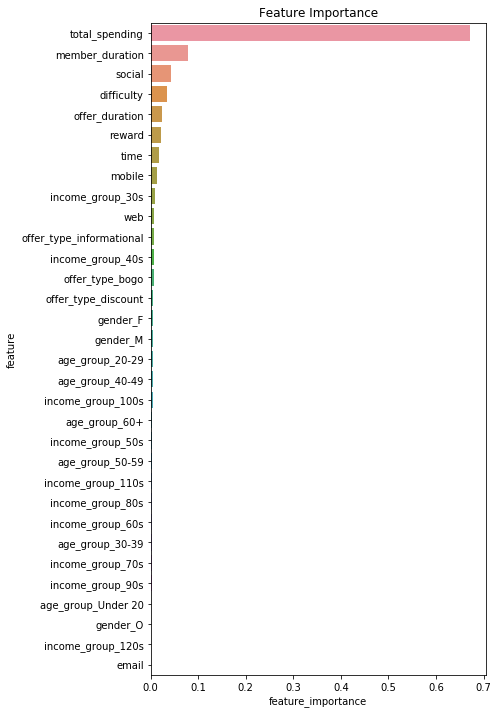

In [85]:
plt.figure(figsize = (6,12))
sns.barplot(data = feat_imp, y = 'feature', x = 'feature_importance')
plt.title('Feature Importance')
plt.show()

- **From the above graph, we can see that how much a customer spends is the biggest influencer on whether or not they respond to an offer. By predicting and understanding how much a customer spends will boost offer response rate.**

- **Membership duration (how long a customer has been a Starbucks Member) can also influence offer response. Long term members have experienced these types of offers in the past. Thus, they understand how they work and which ones are worth it. For a BOGO offer, the customer may save it for when they need to purchase more than one cup (with a companion) or if there was a popular promotional drink.**

- **How offers are delivered to customers can also influence a customer's response. So assigning more quota to one medium may boost response rates.**

- **Difficulty corresponds to how much a customer needs to spend in order to be able to use an offer. This can correlate to how much a customer spends. If difficulty is high and the offer is given to someone who does not spend a lot, then they are less likely to respond.**

- **Duration is how long an offer lasts, given more leeway in when they need to use an offer by can boost response rates. When an offer lasts longer there are more chances for a customer to have some occasion where they will go to Starbucks to make a purchase.**

### Predicting Test Data <a id = "predict-test"></a>

In [80]:
X_test.shape

(18224, 32)

In [81]:
y_test.shape

(18224,)

In [82]:
X_test.head()

,member_duration,time,total_spending,difficulty,offer_duration,reward,email,mobile,social,web,...,income_group_60s,income_group_70s,income_group_80s,income_group_90s,income_group_100s,income_group_110s,income_group_120s,offer_type_bogo,offer_type_discount,offer_type_informational
31224,1256,0.0,72.86,10,7,2,1,1,0,1,...,1,0,0,0,0,0,0,0,1,0
17802,1642,7.0,25.62,10,7,10,1,1,1,0,...,0,0,0,1,0,0,0,1,0,0
3156,1795,14.0,11.67,5,7,5,1,1,0,1,...,1,0,0,0,0,0,0,1,0,0
1566,1538,14.0,76.31,5,7,5,1,1,0,1,...,0,0,0,0,0,0,0,1,0,0
45398,1038,24.0,0.00,20,10,5,1,0,0,1,...,0,1,0,0,0,0,0,0,1,0


In [83]:
y_pred = cv.predict(X_test)
print(y_pred)
print(y_pred.shape)

[1 1 0 ..., 0 1 0]
(18224,)


In [84]:
accuracy_score(y_test, y_pred)

0.8895961369622476

**We achieved 89% accuracy using the tuned RandomForestClassifier!**

# 4. Reflection <a id = "reflection"></a>

This was a very enjoyable project , which incorporated three different datasets. I mainly chose this project because I am an avid visitor to Starbucks and worked at one of the stores for 1.5 years. Whenever I receive an offer, I become particularly excited as it signifies a new promotion and can save me some money (despite not going saves even more).

Looking at the datasets reminded me of a database where each id column is a primary key. Each dataset provides different insights and these insights influenced which features to use for the model. Cleaning the data and figuring out which features to use was fairly quick. The main challenge was merging all the datasets into one while figuring out whether or not a customer responded to an offer.

# 5. Improvements <a id = "improve"></a>

1. Along with predicting if a customer responds to an offer, we can predict how much a customer will spend based on each offer. This coincides with how the feature "spending" influences the model.
2. Working in the advertising industry,  there are many instances where I have to perform customer segmentation. Based on the data we have, if other than the 3 datasets given in this project. If we had access to other apps or content, then we can perform segmentation and create different persona groups. These groups would be based around demographics and/or content each customer is interested in. Simply, segmentation based on products and behavior. This will allow Starbucks to target specific audiences to achieve a higher response rate.